In [6]:
'''
RFI Case 2: Negative RFI from AMSR2
'''


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from contextlib import contextmanager
import xarray as xr
import importlib

@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)

model_path = '/edata2/spencer/rfi_prediction/AMSR2/GCOMW1'

with cd(model_path):
    import sensor_info
    import local_functions
    import model_operations
    importlib.reload(sensor_info)
    importlib.reload(local_functions)
    importlib.reload(model_operations)

rfi_file = '/pdata4/archive/GPM/1Base_AMSR2_V7/1209/120915/1Base.GCOMW1.AMSR2.TB2021.20120915-S135739-E153631.001763.V07A.HDF5'

nchans = 14

with xr.open_dataset(rfi_file, group='S1', decode_timedelta=False) as f:
    lat = f.Latitude_6.values
    lon = f.Longitude_6.values
    nscans, npixs = lat.shape

    Tbs = np.empty([nscans,npixs,nchans])
    Tbs[:,:,0] = f.Tb_6GHz_V.values
    Tbs[:,:,1] = f.Tb_6GHz_H.values
    Tbs[:,:,2] = f.Tb_7GHz_V.values
    Tbs[:,:,3] = f.Tb_7GHz_H.values
    Tbs[:,:,4] = f.Tb_10GHz_V.values
    Tbs[:,:,5] = f.Tb_10GHz_H.values
    Tbs[:,:,6] = f.Tb_18GHz_V.values
    Tbs[:,:,7] = f.Tb_18GHz_H.values
    Tbs[:,:,8] = f.Tb_23GHz_V.values
    Tbs[:,:,9] = f.Tb_23GHz_H.values
    Tbs[:,:,10] = f.Tb_36GHz_V.values
    Tbs[:,:,11] = f.Tb_36GHz_H.values
    Tbs[:,:,12] = f.Tb_89GHz_V_A.values[:,::2]
    Tbs[:,:,13] = f.Tb_89GHz_H_A.values[:,::2]
    
    pdqual = f.Pixel_Data_Quality_6_to_36.values
    

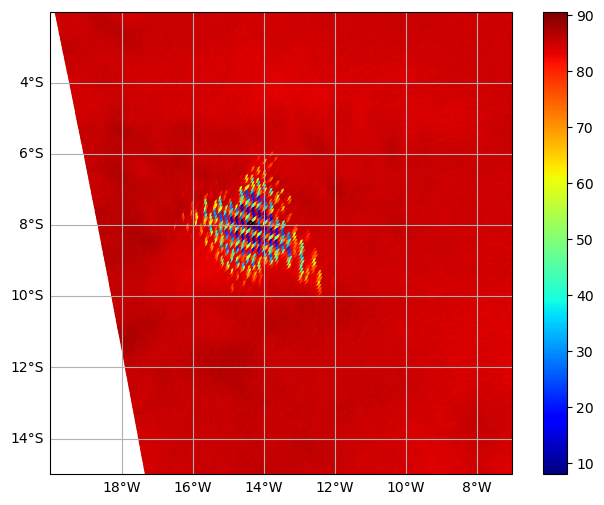

In [2]:
extent = [-20,-7,-15,-2]

within_lat_bounds = np.logical_and(lat <= extent[3], lat >= extent[2])
within_lon_bounds = np.logical_and(lon <= extent[1], lon >= extent[0])
within_bounds = np.logical_and(within_lat_bounds, within_lon_bounds)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(lon[within_bounds], lat[within_bounds], c=Tbs[:,:,1][within_bounds], 
                transform=ccrs.PlateCarree(), s=60., cmap='jet')
#im = ax.scatter(lon, lat, c=pdqual[:,::2], transform=ccrs.PlateCarree(), s=60.,cmap='jet')

plt.colorbar(mappable=im, shrink=1.)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)
plt.show()

In [3]:
data = local_functions.read_amsr2_l1b(rfi_file)

error_threshold = 4

Tbs_ = data['Tbs']
lat = data['lat']
lon = data['lon']
sctime = data['scantime']
good = ~np.isnan(lat)
# lat = lat[good]
# lon = lon[good]
# sctime = sctime[good]
# Tbs = Tbs[good]
sctime = local_functions.copy_columns(sctime, npixs)
#ngoodscans, npixs = lat.shape
nscans,npixs,nchans_ = Tbs_.shape

with cd(model_path):
    #Load model tree
    model_tree = model_operations.load_model_tree()
    
    #Attach surface type to pixels
    sfctype = np.zeros([nscans,npixs], dtype=np.int32)
    sfctype[:] = -99
    sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], lon[good], sctime[good], sensor='AMSR2')
    
    #Predict Tbs
    Tbs_pred = np.zeros_like(Tbs_)
    Tbs_pred[:] = np.nan
    Tbs_pred[good] = model_operations.run_predictions(Tbs_[good], sfctype[good], model_tree, keep_dims=False)

    #Load in stats files
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)
    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)
    #Get error
    epsilon = Tbs_ - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    #Set flag
    mlflag = np.zeros(Tbs_.shape, dtype=np.int32)
    mlflag[epsilon_hat > error_threshold] = 1

/edata2/spencer/rfi_prediction/AMSR2/GCOMW1/local_functions.py:54: RuntimeWarning: invalid value encountered in cast
  qual[:,:,0] = f.Pixel_Data_Quality_6_to_36.values[:,::2]


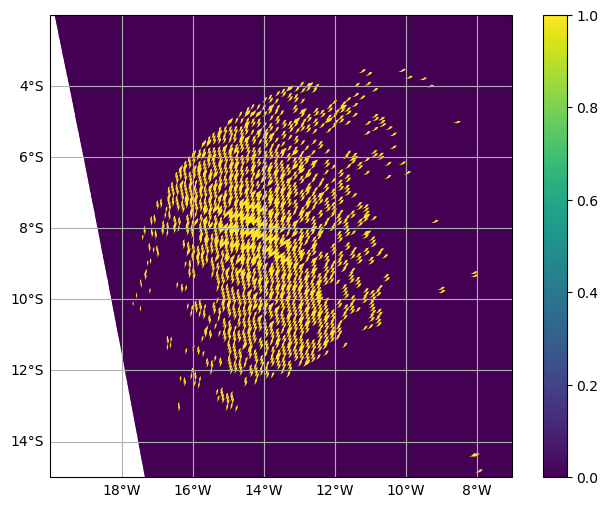

In [4]:
extent = [-20,-7,-15,-2]

within_lat_bounds = np.logical_and(lat <= extent[3], lat >= extent[2])
within_lon_bounds = np.logical_and(lon <= extent[1], lon >= extent[0])
within_bounds = np.logical_and(within_lat_bounds, within_lon_bounds)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(lon[within_bounds], lat[within_bounds], c=mlflag[:,:,1][within_bounds], 
                transform=ccrs.PlateCarree(), s=60., cmap='viridis')
#im = ax.scatter(lon, lat, c=pdqual[:,::2], transform=ccrs.PlateCarree(), s=60.,cmap='jet')

plt.colorbar(mappable=im, shrink=1.)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)
plt.show()

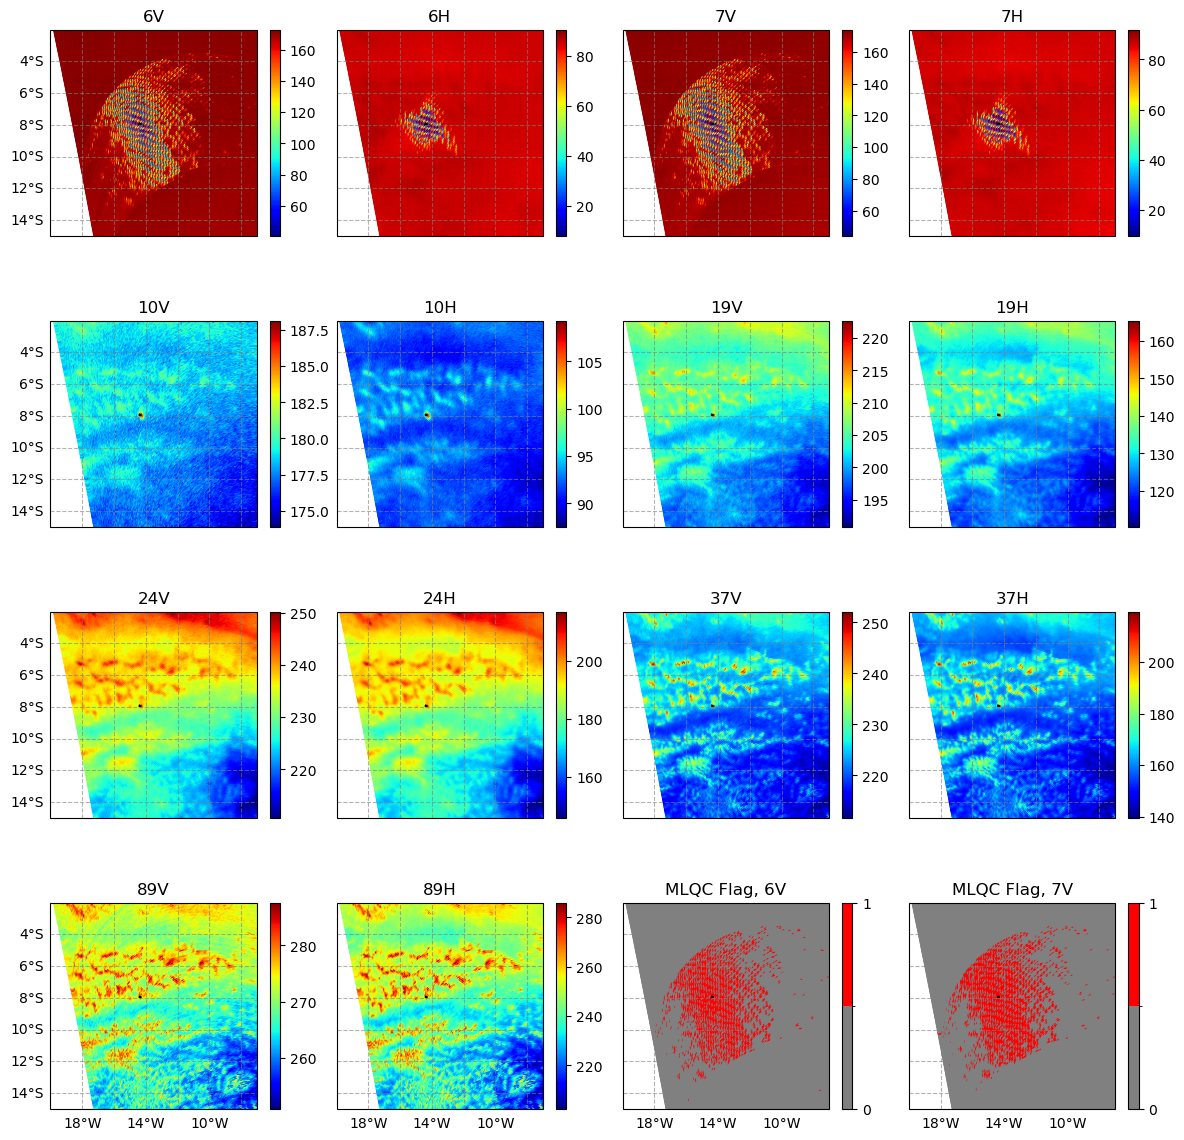

In [15]:

from matplotlib.colors import ListedColormap, BoundaryNorm

extent = [-20,-7,-15,-2]

within_lat_bounds = np.logical_and(lat <= extent[3], lat >= extent[2])
within_lon_bounds = np.logical_and(lon <= extent[1], lon >= extent[0])
within_bounds = np.logical_and(within_lat_bounds, within_lon_bounds)

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)



# Create figure with 2 rows × 3 columns
fig, axes = plt.subplots(4, 4, figsize=(12, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()}, tight_layout=True)

axes = axes.flatten()

# Example plots — update variable indices to your actual data
#im1 = axes[0].scatter(lon[within_bounds], lat[within_bounds], c=qual[within_bounds],
#                      transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=4)
#axes[0].set_title(f'L1C Quality Flag')

for i in range(nchans):
    im1 = axes[i].scatter(lon[within_bounds],lat[within_bounds],c=Tbs[within_bounds,i],
                          transform=ccrs.PlateCarree(), cmap='jet', s=4)
    plt.colorbar(mappable=im1, shrink=0.7)
    if i < nchans - 2:
        axes[i].set_title(f'{sensor_info.feature_descriptions[i]}')
    elif i == nchans - 2:
        axes[i].set_title(f'89V')
    elif i == nchans - 1:
        axes[i].set_title(f'89H')

im2 = axes[-2].scatter(lon[within_bounds], lat[within_bounds], c=mlflag[within_bounds,0],
                       transform=ccrs.PlateCarree(), cmap=cmap, s=4, norm=norm)
cbar = plt.colorbar(mappable=im2, shrink=0.7, ticks=[0,1])
cbar.ax.set_yticklabels(["0", "1"])
axes[-2].set_title(f'MLQC Flag, 6V')
im3 = axes[-1].scatter(lon[within_bounds], lat[within_bounds], c=mlflag[within_bounds,2],
                       transform=ccrs.PlateCarree(), cmap=cmap, s=4, norm=norm)
axes[-1].set_title(f'MLQC Flag, 7V')
cbar = plt.colorbar(mappable=im3, shrink=0.7, ticks=[0,1])
cbar.ax.set_yticklabels(["0", "1"])

for i,ax in enumerate(axes):
    ax.coastlines()
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.6, linestyle='--')
    
    if i == 0 or i == 4 or i == 8:
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
    elif i == 12:
        gl.top_labels = False
        gl.right_labels = False
    elif i == 13 or i == 14 or i == 15:
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False   
    else:
        gl.left_labels = False
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False

# # Add labels only to lower-left plot
# gl = axes[3].gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.6, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False

# Adjust layout for colorbar space
#plt.tight_layout(rect=[0, 0, 0.93, 1])


plt.show()

